# Image Classification Using CNN

## Objectives
- Build image classification CNN using python on the ImageNet datasets.
- CNNs work for the image classification task
- Using TensorFlow’s Keras library to demonstrate image classification using CNNs

## Dataset

There are various datasets that you can leverage for applying convolutional neural networks. Here are three popular datasets:

- MNIST
- CIFAR-10
- ImageNet

## Import Libraries

The algorithm described in Python 3.11.6 will be implemented, using the Keras library (on top of the TensorFlow libraries, which works as a backend). Allows the use of a GPU, if present, to accelerate the computation, which is recommended in the case of this type of networks, since their training is computationally heavy.

Keras has this useful functionality for loading large images (like we have here) without maxing out the RAM, by doing it in small batches.

In [16]:
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout, Activation
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims, argmax

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Download the Imagenette dataset

Once you have downloaded the dataset, you will notice that it has two folders – “train” and “val”. These contain the training and validation set, respectively. Inside each folder, there are separate folders for each class. 

In [2]:
#!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

In [3]:
#!tar -xf imagenette2.tgz

## Global variables

Introduce a configuration set.

In [40]:
# path to the files
path = 'imagenette2'

# batch size based on available memory. 
# It can be any value that fits your GPU or CPU memory. 
# Common to use values like 32, 64, 128, etc.
batch_size  = 32

# input images of size 224x224 pixels with 3 color channels (RGB)
input_shape = (224, 224, 3)

## 1. Preparing the Dataset


The idea of manipulating images with rotation and resizing arises from a basic premise of activities involving Deep Learning and Machine Learning, which is the representativeness of the data sample used to train a model. The larger the sample and the more representative the data used in the training stage, the better the model will perform when classifying new data. Thus, by rotating the images and resizing them, we increase our sample space, generating greater data variability, causing our model to learn characteristics presented in another "form".

In [149]:
# create a new generator

# Uses techniques to generate new images from existing ones (applying random transformations: 
# distortion, rotation, zoom, etc.) for datasets with few images. 
# Obviously, the more images to train, the better the model.

train_image_gen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_image_gen = ImageDataGenerator(rescale = 1./255)

In [150]:
# A good practice is not to pass the entire dataset to the neural network at once. 
# Therefore, it is possible to divide the data set into a number 
# of batches or sets or parts. Give the importance of batch_size

# load train data
train = train_image_gen.flow_from_directory(path +'/train', target_size=input_shape[:2], batch_size = batch_size, class_mode="categorical")

# load val data
val = test_image_gen.flow_from_directory(path +'/val', target_size=input_shape[:2], batch_size = batch_size, class_mode='categorical')
                                                
# The ImageDataGenerator itself inferences the class labels and the number of classes from the folder names.
classes = list(train.class_indices.keys())

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


### List of the 10 classes to classify extracted from the training set.

In [7]:
# class labels and the number of classes from the folder names.
print(classes)

['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


In [8]:
# Creates a list of folders with image categories to be used in the classification test for new images
imagenette_map = { 
    "n01440764" : "tench",
    "n02102040" : "springer",
    "n02979186" : "casette_player",
    "n03000684" : "chain_saw",
    "n03028079" : "church",
    "n03394916" : "French_horn",
    "n03417042" : "garbage_truck",
    "n03425413" : "gas_pump",
    "n03445777" : "golf_ball",
    "n03888257" : "parachute"
}

## 2. Building the model
The trained network (structure and weights) is recorded, so that it can be used again later.

In [41]:
# stack layers to build the architecture of our convolutional network model
# build a sequential model
model = Sequential()

From here we create the CNN, with two convolution layers, where we apply 32 filters to the first convolution, 64 filters to the second, and 128 to the third. At the end of the filter sweep, ReLU is applied, followed by max pooling. After the three convolutions are completed, flattening is performed.

In [42]:
# Convolutional layers
model.add(Conv2D(32, (3,3), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

In [43]:
# Flatten the output before the dense layers
model.add(Flatten())

In this step, the input vector for the neural network is generated, which has a hidden layer of 512 neurons activated again by a ReLU, and a hidden layer of 256 neurons activated again by a ReLU, and which uses the Adam optimizer to apply stochastic gradient descent, and categorical cross entropy as an error function. (loss).

In [44]:
# Dense layers for classification
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

Additionally, if you're working with a binary classification task, you can change the activation function of the output layer to **sigmoid** and set the number of units to 1. For a multi-class classification task, use **softmax** activation with the appropriate number of units.

In [45]:
# output layer
# The output layer has a softmax activation function with the number of 
# units equal to the number of classes in your classification task.
model.add(Dense(10, activation='softmax'))

The **Adam** optimization algorithm is an extension of the Stochatic Gradient Descent. Adam is an adaptive learning rate optimization algorithm developed specifically for training deep neural networks.

The **loss** function is a method of evaluating how well your model handles the data set. If the model is poorly trained, which normally happens depending on the data used, its loss function will produce a high value. If the model is very good, the result will be a lower number. As you change parts of your algorithm to try to improve your model, your loss function tells you whether you are getting anywhere.

In our case we will use **Categorical Cross-entropy**, given that we are addressing a category classification problem.

**Accuracy** is a metric for evaluating classification models. Informally, accuracy is the fraction of predictions that our model gets right.

In [46]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Model architecture summary

In [47]:
# Display the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

## 3. Training the model

In [49]:
results1 = model.fit_generator(train, epochs=30, validation_data=val)

Epoch 1/30


2024-01-30 21:24:19.963239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


296/296 [==============================] - ETA: 0s - loss: 2.1079 - accuracy: 0.2312

2024-01-30 21:26:16.990221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


296/296 [==============================] - 133s 449ms/step - loss: 2.1079 - accuracy: 0.2312 - val_loss: 1.8147 - val_accuracy: 0.3671
Epoch 2/30
296/296 [==============================] - 134s 453ms/step - loss: 1.6899 - accuracy: 0.4161 - val_loss: 1.3941 - val_accuracy: 0.5417
Epoch 3/30
296/296 [==============================] - 134s 451ms/step - loss: 1.5139 - accuracy: 0.4955 - val_loss: 1.3204 - val_accuracy: 0.5755
Epoch 4/30
296/296 [==============================] - 134s 453ms/step - loss: 1.4034 - accuracy: 0.5404 - val_loss: 1.1654 - val_accuracy: 0.6145
Epoch 5/30
296/296 [==============================] - 136s 458ms/step - loss: 1.3134 - accuracy: 0.5717 - val_loss: 1.1376 - val_accuracy: 0.6306
Epoch 6/30
296/296 [==============================] - 134s 453ms/step - loss: 1.2457 - accuracy: 0.5988 - val_loss: 1.0862 - val_accuracy: 0.6578
Epoch 7/30
296/296 [==============================] - 133s 450ms/step - loss: 1.2092 - accuracy: 0.6079 - val_loss: 1.0083 - val_accura

In [50]:
# salve model trained
model.save('cnn_model.h5')

### Printing val_loss history

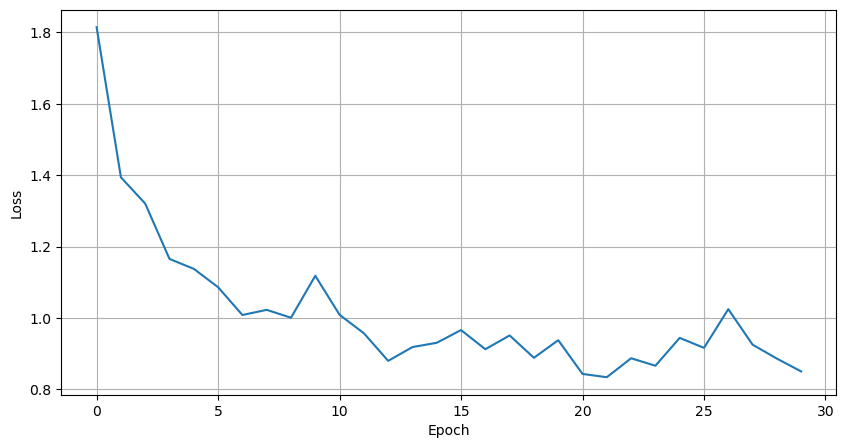

In [51]:
plt.figure(figsize=(10,5))
plt.plot(results1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.savefig('loss_cnn.png')

### Printing val_accuracy history

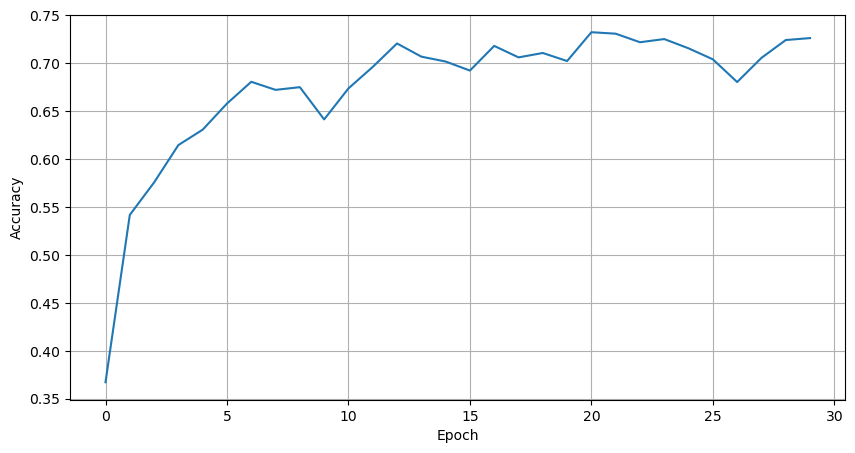

In [52]:
plt.figure(figsize=(10,5))
plt.plot(results1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid()
plt.savefig('accuracy_cnn.png')

## 3. Transfer learning (VGG16) to improve accuracy

### Create a new generator and prepare dataset

In [146]:
# create a new generator
imagegen = ImageDataGenerator()
# load train data
train_transf = imagegen.flow_from_directory(path + "/train/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))
# load val data
val_transf = imagegen.flow_from_directory(path + "/val/", class_mode="categorical", shuffle=False, batch_size=128, target_size=(224, 224))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


### Downloading weights of VGG16

In [147]:
from keras.applications import VGG16

# include top should be False to remove the softmax layer
pretrained_model_vgg = VGG16(include_top=False, weights='imagenet')
    
pretrained_model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### Generate features from VGG16

#### Extract useful features that VGG16 already knows from our dataset’s images

In [148]:
# extract train and val features
vgg_train = pretrained_model_vgg.predict(train_transf)
vgg_test = pretrained_model_vgg.predict(val_transf)

2024-01-31 01:59:21.481121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


74/74 [==============================] - 635s 9s/step


2024-01-31 02:09:57.233054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 266s 9s/step


#### OHE target column

In [151]:
from keras.utils import to_categorical

train_target = to_categorical(train_transf.labels)
test_target = to_categorical(val_transf.labels)

#### Once the above features are ready, use them for training a basic, Fully Connected Neural Network in Keras

In [164]:
# building the model
model2 = Sequential()
model2.add(Flatten(input_shape=((7,7,512))))
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(10, activation='softmax'))

# compile the model
model2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [165]:
model2.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_28 (Flatten)        (None, 25088)             0         
                                                                 
 dense_73 (Dense)            (None, 256)               6422784   
                                                                 
 dropout_35 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_572 (Ba  (None, 256)              1024      
 tchNormalization)                                               
                                                                 
 dense_74 (Dense)            (None, 10)                2570      
                                                                 
Total params: 6,426,378
Trainable params: 6,425,866
Non-trainable params: 512
_________________________________________

#### Train model using features generated from VGG16 model

In [166]:
results2 = model2.fit(vgg_train, train_target, epochs=50, batch_size=128, validation_data=(vgg_test, test_target))

Epoch 1/50
74/74 [==============================] - 2s 18ms/step - loss: 0.3234 - accuracy: 0.9051 - val_loss: 0.1849 - val_accuracy: 0.9468
Epoch 2/50
74/74 [==============================] - 1s 17ms/step - loss: 0.0624 - accuracy: 0.9873 - val_loss: 0.1709 - val_accuracy: 0.9455
Epoch 3/50
74/74 [==============================] - 1s 17ms/step - loss: 0.0225 - accuracy: 0.9985 - val_loss: 0.1671 - val_accuracy: 0.9485
Epoch 4/50
74/74 [==============================] - 1s 17ms/step - loss: 0.0098 - accuracy: 0.9998 - val_loss: 0.1654 - val_accuracy: 0.9480
Epoch 5/50
74/74 [==============================] - 1s 17ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1671 - val_accuracy: 0.9485
Epoch 6/50
74/74 [==============================] - 1s 17ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.1691 - val_accuracy: 0.9460
Epoch 7/50
74/74 [==============================] - 1s 17ms/step - loss: 0.0036 - accuracy: 0.9999 - val_loss: 0.1708 - val_accuracy: 0.9465
Epoch 8/50
74

In [167]:
# salve model trained
model2.save('fcnn_vgg_model.h5')

## 4. Trying to improve using other models

### ResNet

In [168]:
from tensorflow.keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D

pretrained_ResNet50 = ResNet50(weights='imagenet', include_top=False)

# extract train and val features
restnet_train = pretrained_ResNet50.predict(train_transf)
restnet_test = pretrained_ResNet50.predict(val_transf)

# Building Model
model3 = Sequential()
model3.add(Flatten(input_shape=((7,7,2048))))
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.5))
model2.add(BatchNormalization())
model3.add(Dense(10, activation='softmax'))

# Compile Model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary Model
model3.summary()

# Train Model
results3 = model3.fit(restnet_train, train_target, epochs=50, batch_size=128, validation_data=(restnet_test, test_target))

2024-01-31 02:23:55.872106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


74/74 [==============================] - 201s 3s/step


2024-01-31 02:27:20.165195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 81s 3s/step
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_29 (Flatten)        (None, 100352)            0         
                                                                 
 dense_75 (Dense)            (None, 256)               25690368  
                                                                 
 dropout_36 (Dropout)        (None, 256)               0         
                                                                 
 dense_76 (Dense)            (None, 10)                2570      
                                                                 
Total params: 25,692,938
Trainable params: 25,692,938
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
74/74 [==============================] - 5s 71ms/step - loss: 3.2531 - accuracy: 0.8134 - val_loss: 0.3352 - 

In [169]:
# salve model trained
model3.save('fcnn_restnet_model.h5')

### InceptionV3

In [170]:
from tensorflow.keras.applications import InceptionV3

pretrained_Inception = InceptionV3(weights='imagenet', include_top=False)

# extract train and val features
inception_train = pretrained_Inception.predict(train_transf)
inception_test = pretrained_Inception.predict(val_transf)

model4 = Sequential()
model4.add(Flatten(input_shape=((5,5,2048))))
model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.5))
model2.add(BatchNormalization())
model4.add(Dense(10, activation='softmax'))

# Compile Model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary Model
model4.summary()

# Train Model
results4 = model4.fit(inception_train, train_target, epochs=50, batch_size=128, validation_data=(inception_test, test_target))

2024-01-31 02:34:56.058765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


74/74 [==============================] - 131s 2s/step


2024-01-31 02:37:09.123093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 54s 2s/step
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_30 (Flatten)        (None, 51200)             0         
                                                                 
 dense_77 (Dense)            (None, 256)               13107456  
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_78 (Dense)            (None, 10)                2570      
                                                                 
Total params: 13,110,026
Trainable params: 13,110,026
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
74/74 [==============================] - 3s 36ms/step - loss: 50.3063 - accuracy: 0.1152 - val_loss: 2.3043 -

In [171]:
# salve model trained
model4.save('fcnn_inception_model.h5')

### EfficientNet

In [174]:
from tensorflow.keras.applications import EfficientNetB0

pretrained_EfficientNet = EfficientNetB0(weights='imagenet', include_top=False)

# extract train and val features
efficientNet_train = pretrained_EfficientNet.predict(train_transf)
efficientNet_test = pretrained_EfficientNet.predict(val_transf)

model5 = Sequential()
model5.add(Flatten(input_shape=((7,7,1280))))
model5.add(Dense(256, activation='relu'))
model5.add(Dropout(0.5))
model2.add(BatchNormalization())
model5.add(Dense(10, activation='softmax'))

# Compile Model
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary Model
model5.summary()

# Train Model
results5 = model5.fit(efficientNet_train, train_target, epochs=50, batch_size=128, validation_data=(efficientNet_test, test_target))

2024-01-31 02:49:27.954472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


74/74 [==============================] - 80s 1s/step


2024-01-31 02:50:50.292801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


31/31 [==============================] - 32s 1s/step
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_33 (Flatten)        (None, 62720)             0         
                                                                 
 dense_83 (Dense)            (None, 256)               16056576  
                                                                 
 dropout_40 (Dropout)        (None, 256)               0         
                                                                 
 dense_84 (Dense)            (None, 10)                2570      
                                                                 
Total params: 16,059,146
Trainable params: 16,059,146
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
74/74 [==============================] - 3s 45ms/step - loss: 0.4046 - accuracy: 0.9488 - val_loss: 0.1349 - 

In [175]:
# salve model trained
model5.save('fcnn_efficientNet_model.h5')

## 5. Load a previously trained network and ask it to identify the images.

1/1 [==============================] - 0s 74ms/step


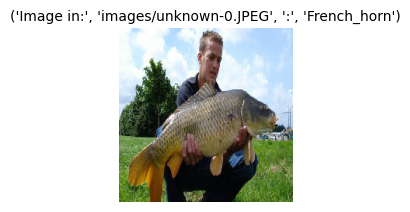

1/1 [==============================] - 0s 22ms/step


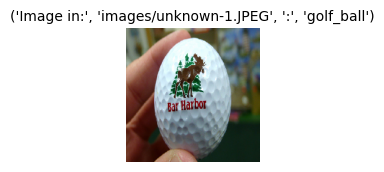

1/1 [==============================] - 0s 22ms/step


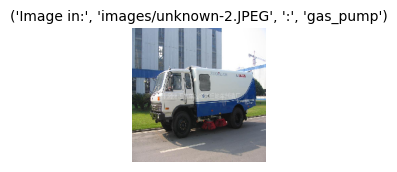

1/1 [==============================] - 0s 22ms/step


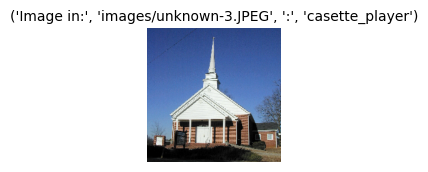

1/1 [==============================] - 0s 22ms/step


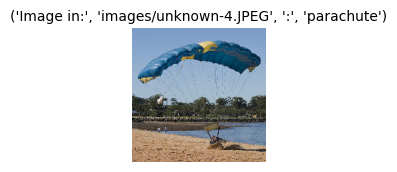

1/1 [==============================] - 0s 22ms/step


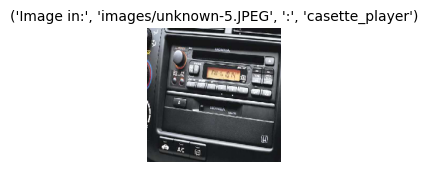

In [198]:
import keras.utils as image
import numpy as np
import matplotlib.pyplot as plt

cnn = load_model('cnn_model.h5')
#cnn = load_model('fcnn_vgg_model.h5')
#cnn = load_model('fcnn_efficientNet_model.h5')

# Setting the size of the figure
plt.figure(figsize=(3 * 3, 2 * 3))

for i in range(0, 6):
    file = 'images/unknown-' + str(i) + '.JPEG'
    img = image.load_img(file, target_size = (224,224))
    y = cnn.predict(expand_dims(image.img_to_array(img), axis = 0))
    class_name = imagenette_map.get(classes[argmax(y)], "Unidentified image")    
    legend = 'Image in:', file, ':', class_name
    
    # Add the image to the figure
    plt.subplot(3, 2,1)
    plt.imshow(img)

    # Add a caption to the image
    plt.title(legend, fontsize=10)

    plt.axis('off') # Do not show axes

    plt.tight_layout()
    plt.show() 